**Notebook 1 – Introduction to Artificial Neural Networks with Keras**

_This notebook introduces ANNs._
jens.schwarzbach@ukr.de

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/jvschw/blob/ml4ni/1_introduction_to_neural_nets_with_keras.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

# Intro

Advance with SHIFT ENTER

## Biological and artificial neurons 

An Artificial Neural Network (ANN) is a Machine Learning Model inspired by the networks of biological neurons found in the brain. Neurons receive input through the synapses on their dentritic branches, which leads to changes of the neuron's membrane potential. If the membrane potential falls below a certain threshold, the neuron creates an action potential, which travels down the axon and eventually reaches the synaptic terminals where the neuron makes contact with other neurons.

<img src="images/ann/Blausen_0657_MultipolarNeuron_small2.png">

Neuronal activity is frequency encoded. This means, the more excitatory input the neuron receives the higher its firing rate (measured in spikes per second or Hz) becomes. Below, you see how the spike rate (scaled to 100%) of four neurons in primary visual cortex (V1) increases as a function of stimulus contrast [(Albrecht & Hamilton, 1982)](https://www.physiology.org/doi/abs/10.1152/jn.1982.48.1.217).

<img src="images/ann/CRF_Albrecht_Hamilton_1982_small.jpg">

This input-output dependency can be captured mathematically by a perceptron, an artificial neuron that computes the weighted sum of its inputs (input x synaptic strength) which then is passed to an activation function, which determines the output of that neuron. 

<img src="images/ann/Rosenblattperceptron.png">

Artificial neurons can be equipped with a host of different activation functions. The left panel in the figure below shows some of the most common activation functions, the right panel shows their respective derivatives.
Derivatives are important, since learning yields the strongest changes where the derivative is highest.

<img src="images/ann/activation_functions_plot.png">

## Neural Networks

ANNs consist of different layers of (artificial) neurons, typically one input layer (red), one output layer (blue), and a variable number of hidden layers (yellow) in between. Neurons in one layer are connected to neurons in subsequent layers by means of (synaptic) weights. 

<img src="images/ann/ANN_example.jpg">

# Simulating ANNs with KERAS

## Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

**Note**: we set `max_iter` and `tol` explicitly to avoid warnings about the fact that their default value will change in future versions of Scikit-Learn.

## Building an Image Classifier

First let's import TensorFlow and Keras.

Tensorflow is a library for numerical computation developed by the Google Brain Team. In mathematics, a tensor is an algebraic object that describes a linear mapping from one set of algebraic objects (e.g.  a scalar, vector or matrix) to another. In case of ANNs this means how the activity of one neuronal layer is transformed to another layer.

Keras is a high-level neural networks application programming interface (API), written in Python and capable of running on top of TensorFlow, and other libraries such as CNTK or Theano. It was developed with a focus on enabling fast experimentation.

In [2]:
import tensorflow as tf
from tensorflow import keras

In [3]:
#which version is installed?
tf.__version__

'2.1.0'

In [4]:
#which version is installed?
keras.__version__

'2.2.4-tf'

Now, let's load the fashion MNIST dataset. Keras has a number of functions to load popular datasets in `keras.datasets`. 
The training data is a matrix (X) with the dimensions [nSamples, nFeatures]. The labels are contained in a vector (y) with nFeatures elements.
The dataset is already split for you between a training set and a test set, but it can be useful to split the training set further to have a validation set:

In [5]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

The training set contains 60,000 grayscale images, each 28x28 pixels:

In [6]:
X_train_full.shape

(60000, 28, 28)

and of 60,000 class labels, each of which being a number from 0-9: 

The test set contains 10,000 grayscale images, each 28x28 pixels:

In [59]:
y_train_full.shape

(60000,)

The test set contains 10,000 grayscale images, each 28x28 pixels:

In [8]:
X_test.shape

(10000, 28, 28)

and 10,000 class labels, each of which being a number from 0-9: 

In [9]:
y_test.shape

(10000,)

Each pixel intensity is represented as a byte (0 to 255):

In [10]:
X_train_full.dtype

dtype('uint8')

Let's split the full training set into a validation set and a (smaller) training set. We also scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255.

In [37]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

In [36]:
X_train.shape

(55000, 28, 28)

In [38]:
X_valid.shape

(5000, 28, 28)

In [39]:
X_test.shape

(10000, 28, 28)

You can plot an image using Matplotlib's `imshow()` function, with a `'binary'`
 color map:

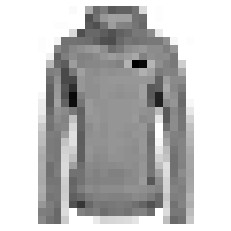

In [12]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

The labels are the class IDs (represented as uint8), from 0 to 9:

In [13]:
y_train

array([2, 9, 6, ..., 3, 0, 5], dtype=uint8)

Here are the corresponding class names:

In [14]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

So the first image in the training set is a coat:

In [15]:
class_names[y_train[0]]

'Pullover'

The validation set contains 5,000 images, and the test set contains 10,000 images:

In [16]:
X_valid.shape

(5000, 28, 28)

In [17]:
X_test.shape

(10000, 28, 28)

Let's take a look at a sample of the images in the dataset:

In [ ]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_plot', tight_layout=False)
plt.show()

We start a keras session and initialize the random-seed generator to a fixed value such that we can replicate the session.
Then we build a sequential model with keras. Sequential means that the information flows sequentially from one layer to the next.
We start with an input layer, then we add two hidden layers (the first with 300 neurons, the second with 100 neurons), which are densely connected (dense means each unit of a given layer is connected to each unit to the preceding layer, as opposed to sparse connections). Both hidden layers use the relu activation function. Finally, we add an output layer with 10 neurons (because we have 10 output categories) and a softmax activation function, which gives us the probability of the class a neuron represents (all neurons sum up to a probability of 1).


In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

'model.summary' provides us with a text-description of our model 

In [ ]:
model.summary()

Keras has a function that produces a graphical depiction of a model. [Note: the ? in the numerical descriptions denotes the batch-size, which we have not defined yet. More about batch-sizes further below when we talk about the model's optimizing function.]

In [ ]:
keras.utils.plot_model(model, "my_mnist_model.png", show_shapes=True)

We can access layers and use variables to refer to them:

In [ ]:
hidden1 = model.layers[1]
hidden1.name

In [ ]:
model.get_layer(hidden1.name) is hidden1

In [ ]:
weights, biases = hidden1.get_weights()

Weights are initialized with small random values, otherwise there would not be any gradients and the model would be unable to learn.

In [ ]:
weights

The first hidden layer gets its input from the input layer, which has 784 (i.e. 28x28) units. The first hidden layer itself has 300 units. We can look at the shape of the weight matrix. You see it is organized as (from, to).

In [ ]:
weights.shape

Biases are initialized with zeroes.

In [ ]:
biases

Each unit has its own bias.

In [ ]:
biases.shape

Now we are ready to compile the model, for which we have to provide three more pieces of information: 1) the loss function (here sparse_categorical_crossentropy), 2) the optimizer for learning (here stochastic gradient descent), and 3) the performance metrics (here accuracy).

Why 'sparse_categorical_crossentropy'?
We have sparse labels (0, 1, 2, 3, 4, 5, 6, 7, 8, 9) with nothing in between, and these labels are mutually exclusive.

If we had used one-hot encoding, such as [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.] to represent class 3, we would need to use the "categorical_crossentropy" loss instead.

If we were doing binary classification (e.g. patient vs control) with one or more binary labels (e.g. patient vs control, male vs female),  we would use the sigmoid (i.e. logistic) activation function in the output layer instead of the "softmax" function, and we would use the "binary_crossentropy" loss.

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

This is equivalent to:

```python
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.SGD(),
              metrics=[keras.metrics.sparse_categorical_accuracy])
```

We have set up the data and model. Now we need to tell the learning algorithm how many epochs (i.e. one loop through all training samples) to run and set the batch size.
Stochastic Gradient Descent performs a weight update for every batch (i.e. a subset) of training data, implying there are multiple weight updates per epoch instead of going through all samples and computing one weight update per epoch. This approach leads to a faster, more stable convergence. There is a discussion about optimal batch sizes: one strategy is to make batches as large as possible such that they fit in the memory of a GPU. This strategy optimizes parallelization. But there are claims that large batch sizes lead to instable learning (which could be countered by learning-rate warmup, i.e. start with smaller learning rates, increase the learning rate for a while and later decrease it again). The alternative, and that is the approach we take here is to use a batch size of 32 samples or less.

Now we are ready to fit the model (and grab a coffee).

In [ ]:
history = model.fit(X_train, y_train, epochs=30, batch_size=32,
                    validation_data=(X_valid, y_valid))

Fitting a model provides us with a history object that contains a lot of information about the learning history.

In [ ]:
history.params

In [ ]:
print(history.epoch)

In [ ]:
history.history.keys()

Most importantly, history contains a dictionary (history.history) containing the loss and extra metrics it measured at the end of each epoch on the training set and on the validation set.
You can create a pandas data frame from history.history and plot the learning curves below.

In [ ]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(False)
plt.gca().set_ylim(0, 1)
save_fig("keras_learning_curves_plot")
plt.show()

Both the training accuracy and the validation accuracy steadily increase during training, while the training loss and the validation loss decrease. Moreover, since the validation curves are close to the training curves, there seems to be no problem with overfitting.

## Hyperparameter Tuning

At this point our model predicts the labels of the validation dataset with an accuracy of 87.2%. Not too bad, but is this the best we can do?

In [18]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [55]:
def build_model(n_hidden=2, n_neurons=30, learning_rate=3e-3, input_shape=[28, 28]):
    print(n_hidden, n_neurons, learning_rate)
    model = keras.models.Sequential()   
    model.add(keras.layers.Flatten(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(10, activation="softmax"))
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    #model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer)
    return model

In [56]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

In [58]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

#param_distribs = {
#    #"n_hidden": [1, 2], #[0, 1, 2, 3],
#    #"n_neurons": np.arange(1, 100),
#    "learning_rate": reciprocal(3e-4, 3e-2),
#}

param_distribs = {
    "n_neurons": np.arange(50, 300),
    "learning_rate": [.1, .01, .001, .0001 , .00001],
}


rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3, verbose=2)
rnd_search_cv.fit(X_train, y_train, epochs=30,
    validation_data=(X_valid, y_valid),
    callbacks=[keras.callbacks.EarlyStopping(patience=10)])


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] n_neurons=82, learning_rate=1e-05 ...............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


2 82 1e-05
Train on 36666 samples, validate on 5000 samples
Epoch 1/30
36666/36666 [==============================] - 3s 87us/sample - loss: 2.3181 - accuracy: 0.1583 - val_loss: 2.3058 - val_accuracy: 0.1608
Epoch 2/30
36666/36666 [==============================] - 3s 88us/sample - loss: 2.2914 - accuracy: 0.1647 - val_loss: 2.2805 - val_accuracy: 0.1706
Epoch 3/30
36666/36666 [==============================] - 4s 112us/sample - loss: 2.2677 - accuracy: 0.1772 - val_loss: 2.2580 - val_accuracy: 0.1858
Epoch 4/30
36666/36666 [==============================] - 4s 106us/sample - loss: 2.2466 - accuracy: 0.1945 - val_loss: 2.2380 - val_accuracy: 0.2056
Epoch 5/30
36666/36666 [==============================] - 5s 148us/sample - loss: 2.2280 - accuracy: 0.2138 - val_loss: 2.2203 - val_accuracy: 0.2248
Epoch 6/30
36666/36666 [==============================] - 3s 71us/sample - loss: 2.2114 - accuracy: 0.2321 - val_loss: 2.2045 - val_accuracy: 0.2410
Epoch 7/30
36666/36666 [===================

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.8min remaining:    0.0s


2 82 1e-05
Train on 36667 samples, validate on 5000 samples
Epoch 1/30
36667/36667 [==============================] - 3s 84us/sample - loss: 2.4688 - accuracy: 0.0991 - val_loss: 2.4597 - val_accuracy: 0.0970
Epoch 2/30
36667/36667 [==============================] - 3s 89us/sample - loss: 2.4457 - accuracy: 0.0992 - val_loss: 2.4375 - val_accuracy: 0.0970
Epoch 3/30
36667/36667 [==============================] - 3s 70us/sample - loss: 2.4244 - accuracy: 0.0993 - val_loss: 2.4168 - val_accuracy: 0.0970
Epoch 4/30
36667/36667 [==============================] - 2s 66us/sample - loss: 2.4045 - accuracy: 0.0997 - val_loss: 2.3975 - val_accuracy: 0.0976
Epoch 5/30
36667/36667 [==============================] - 2s 67us/sample - loss: 2.3859 - accuracy: 0.0998 - val_loss: 2.3794 - val_accuracy: 0.0980
Epoch 6/30
36667/36667 [==============================] - 3s 85us/sample - loss: 2.3685 - accuracy: 0.1010 - val_loss: 2.3624 - val_accuracy: 0.0984
Epoch 7/30
36667/36667 [======================

Epoch 14/30
36667/36667 [==============================] - 3s 92us/sample - loss: 2.1442 - accuracy: 0.2494 - val_loss: 2.1389 - val_accuracy: 0.2582
Epoch 15/30
36667/36667 [==============================] - 3s 95us/sample - loss: 2.1303 - accuracy: 0.2631 - val_loss: 2.1248 - val_accuracy: 0.2724
Epoch 16/30
36667/36667 [==============================] - 4s 113us/sample - loss: 2.1167 - accuracy: 0.2765 - val_loss: 2.1110 - val_accuracy: 0.2848
Epoch 17/30
36667/36667 [==============================] - 3s 94us/sample - loss: 2.1034 - accuracy: 0.2887 - val_loss: 2.0976 - val_accuracy: 0.2928
Epoch 18/30
36667/36667 [==============================] - 4s 107us/sample - loss: 2.0904 - accuracy: 0.2987 - val_loss: 2.0844 - val_accuracy: 0.3012
Epoch 19/30
36667/36667 [==============================] - 3s 80us/sample - loss: 2.0776 - accuracy: 0.3072 - val_loss: 2.0714 - val_accuracy: 0.3086
Epoch 20/30
36667/36667 [==============================] - 3s 94us/sample - loss: 2.0651 - accurac

36667/36667 [==============================] - 4s 96us/sample - loss: 0.8206 - accuracy: 0.7437 - val_loss: 0.7988 - val_accuracy: 0.7522
Epoch 27/30
36667/36667 [==============================] - 4s 101us/sample - loss: 0.8098 - accuracy: 0.7465 - val_loss: 0.7881 - val_accuracy: 0.7582
Epoch 28/30
36667/36667 [==============================] - 4s 101us/sample - loss: 0.7996 - accuracy: 0.7496 - val_loss: 0.7786 - val_accuracy: 0.7596
Epoch 29/30
36667/36667 [==============================] - 4s 102us/sample - loss: 0.7900 - accuracy: 0.7521 - val_loss: 0.7689 - val_accuracy: 0.7608
Epoch 30/30
18333/18333 [==============================] - 1s 56us/sample - loss: 0.7748 - accuracy: 0.7599
[CV] .............. n_neurons=253, learning_rate=0.0001, total= 2.0min
[CV] n_neurons=253, learning_rate=0.0001 .............................
2 253 0.0001
Train on 36667 samples, validate on 5000 samples
Epoch 1/30
36667/36667 [==============================] - 4s 106us/sample - loss: 2.2480 - accura

36667/36667 [==============================] - 4s 106us/sample - loss: 0.4118 - accuracy: 0.8544 - val_loss: 0.4112 - val_accuracy: 0.8590
Epoch 7/30
36667/36667 [==============================] - 4s 108us/sample - loss: 0.3960 - accuracy: 0.8620 - val_loss: 0.3972 - val_accuracy: 0.8618
Epoch 8/30
36667/36667 [==============================] - 4s 109us/sample - loss: 0.3840 - accuracy: 0.8644 - val_loss: 0.3829 - val_accuracy: 0.8696
Epoch 9/30
36667/36667 [==============================] - 4s 106us/sample - loss: 0.3727 - accuracy: 0.8681 - val_loss: 0.3942 - val_accuracy: 0.8580
Epoch 10/30
36667/36667 [==============================] - 4s 107us/sample - loss: 0.3619 - accuracy: 0.8718 - val_loss: 0.3750 - val_accuracy: 0.8714
Epoch 11/30
36667/36667 [==============================] - 4s 107us/sample - loss: 0.3515 - accuracy: 0.8754 - val_loss: 0.3718 - val_accuracy: 0.8704
Epoch 12/30
36667/36667 [==============================] - 4s 106us/sample - loss: 0.3453 - accuracy: 0.8765 

Epoch 19/30
36667/36667 [==============================] - 3s 94us/sample - loss: 0.9387 - accuracy: 0.7120 - val_loss: 0.9112 - val_accuracy: 0.7214
Epoch 20/30
36667/36667 [==============================] - 4s 98us/sample - loss: 0.9184 - accuracy: 0.7159 - val_loss: 0.8918 - val_accuracy: 0.7232
Epoch 21/30
36667/36667 [==============================] - 4s 96us/sample - loss: 0.8999 - accuracy: 0.7207 - val_loss: 0.8742 - val_accuracy: 0.7272
Epoch 22/30
36667/36667 [==============================] - 4s 116us/sample - loss: 0.8830 - accuracy: 0.7227 - val_loss: 0.8582 - val_accuracy: 0.7310
Epoch 23/30
36667/36667 [==============================] - 4s 101us/sample - loss: 0.8674 - accuracy: 0.7263 - val_loss: 0.8431 - val_accuracy: 0.7342
Epoch 24/30
36667/36667 [==============================] - 4s 97us/sample - loss: 0.8532 - accuracy: 0.7289 - val_loss: 0.8296 - val_accuracy: 0.7384
Epoch 25/30
36667/36667 [==============================] - 4s 96us/sample - loss: 0.8401 - accurac

18333/18333 [==============================] - 1s 54us/sample - loss: 1.8409 - accuracy: 0.5039
[CV] ............... n_neurons=247, learning_rate=1e-05, total= 1.9min
[CV] n_neurons=241, learning_rate=1e-05 ..............................
2 241 1e-05
Train on 36666 samples, validate on 5000 samples
Epoch 1/30
36666/36666 [==============================] - 4s 105us/sample - loss: 2.3298 - accuracy: 0.2263 - val_loss: 2.3204 - val_accuracy: 0.2266
Epoch 2/30
36666/36666 [==============================] - 4s 96us/sample - loss: 2.2980 - accuracy: 0.2418 - val_loss: 2.2897 - val_accuracy: 0.2400
Epoch 3/30
36666/36666 [==============================] - 3s 94us/sample - loss: 2.2688 - accuracy: 0.2567 - val_loss: 2.2613 - val_accuracy: 0.2570
Epoch 4/30
36666/36666 [==============================] - 3s 95us/sample - loss: 2.2419 - accuracy: 0.2735 - val_loss: 2.2351 - val_accuracy: 0.2718
Epoch 5/30
36666/36666 [==============================] - 3s 95us/sample - loss: 2.2169 - accuracy: 0.28

Epoch 12/30
36666/36666 [==============================] - 4s 105us/sample - loss: 0.2354 - accuracy: 0.9100 - val_loss: 0.3175 - val_accuracy: 0.8886
Epoch 13/30
36666/36666 [==============================] - 4s 105us/sample - loss: 0.2267 - accuracy: 0.9146 - val_loss: 0.3148 - val_accuracy: 0.8840
Epoch 14/30
36666/36666 [==============================] - 4s 111us/sample - loss: 0.2172 - accuracy: 0.9192 - val_loss: 0.3613 - val_accuracy: 0.8748
Epoch 15/30
36666/36666 [==============================] - 4s 104us/sample - loss: 0.2109 - accuracy: 0.9194 - val_loss: 0.3213 - val_accuracy: 0.8894
Epoch 16/30
36666/36666 [==============================] - 4s 106us/sample - loss: 0.2026 - accuracy: 0.9232 - val_loss: 0.3239 - val_accuracy: 0.8882
Epoch 17/30
36666/36666 [==============================] - 4s 102us/sample - loss: 0.1973 - accuracy: 0.9249 - val_loss: 0.3267 - val_accuracy: 0.8908
Epoch 18/30
36666/36666 [==============================] - 4s 104us/sample - loss: 0.1891 - ac

18334/18334 [==============================] - 1s 61us/sample - loss: 0.7844 - accuracy: 0.7437
[CV] .............. n_neurons=245, learning_rate=0.0001, total= 2.0min
[CV] n_neurons=245, learning_rate=0.0001 .............................
2 245 0.0001
Train on 36667 samples, validate on 5000 samples
Epoch 1/30
36667/36667 [==============================] - 4s 108us/sample - loss: 2.2138 - accuracy: 0.2110 - val_loss: 2.1090 - val_accuracy: 0.3134
Epoch 2/30
36667/36667 [==============================] - 4s 103us/sample - loss: 2.0262 - accuracy: 0.4132 - val_loss: 1.9442 - val_accuracy: 0.4904
Epoch 3/30
36667/36667 [==============================] - 4s 100us/sample - loss: 1.8783 - accuracy: 0.5250 - val_loss: 1.8037 - val_accuracy: 0.5652
Epoch 4/30
36667/36667 [==============================] - 4s 105us/sample - loss: 1.7486 - accuracy: 0.5716 - val_loss: 1.6791 - val_accuracy: 0.5948
Epoch 5/30
36667/36667 [==============================] - 4s 106us/sample - loss: 1.6324 - accuracy:

36667/36667 [==============================] - 3s 81us/sample - loss: 1.3491 - accuracy: 0.6297 - val_loss: 1.3024 - val_accuracy: 0.6520
Epoch 12/30
36667/36667 [==============================] - 3s 79us/sample - loss: 1.2921 - accuracy: 0.6393 - val_loss: 1.2481 - val_accuracy: 0.6590
Epoch 13/30
36667/36667 [==============================] - 3s 80us/sample - loss: 1.2410 - accuracy: 0.6467 - val_loss: 1.1995 - val_accuracy: 0.6644
Epoch 14/30
36667/36667 [==============================] - 3s 79us/sample - loss: 1.1951 - accuracy: 0.6531 - val_loss: 1.1561 - val_accuracy: 0.6698
Epoch 15/30
36667/36667 [==============================] - 3s 78us/sample - loss: 1.1541 - accuracy: 0.6595 - val_loss: 1.1172 - val_accuracy: 0.6744
Epoch 16/30
36667/36667 [==============================] - 3s 79us/sample - loss: 1.1174 - accuracy: 0.6647 - val_loss: 1.0827 - val_accuracy: 0.6820
Epoch 17/30
36667/36667 [==============================] - 3s 80us/sample - loss: 1.0848 - accuracy: 0.6699 - va

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 55.1min finished


RuntimeError: Cannot clone object <tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x14b5cf320>, as the constructor either does not set or modifies parameter n_neurons

In [30]:
rnd_search_cv.best_params_

In [40]:
rnd_search_cv.best_score_

{'n_hidden': 2, 'learning_rate': 0.1}

In [ ]:
rnd_search_cv.best_estimator_

In [ ]:
model = rnd_search_cv.best_estimator_.model

## Testing the model

Let's assume we are satisfied with the model's validation accuracy. The next step is to evaluate the model on the test data to see whether it generalizes well to data it has not seen before.

In [ ]:
model.evaluate(X_test, y_test)

## Using the model to make predictions

Let's predict the labels of the first three elements from the test set. For each test item you will see ten probabilities, i.e. the probability that a given item belongs to each of the respective output classes.

In [ ]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

We can directly output the label of the winning class per test element.

In [ ]:
y_pred = model.predict_classes(X_new)
y_pred

We can also output the respective names of the winning classes.

In [ ]:
np.array(class_names)[y_pred]

In [ ]:
y_new = y_test[:3]
y_new

Last, but not least, we can plot the pictures for which we wanted to predict the labels and compare human and artificial intelligence.

In [ ]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_images_plot', tight_layout=False)
plt.show()